### This notebook aims to get a deeper understanding of the dataset domain

In [246]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib import colors as mcolors

### Age extraction

In [247]:
users = pd.read_csv('Data/userlist_filt.csv')
users['birth_date'] = pd.to_datetime(users['birth_date'],errors='coerce')
users['age'] = ((pd.to_datetime('2018-01-01') - users['birth_date'])/pd.Timedelta(days=365.25)).dropna().round()
users = users[users['age'] > 12] # While there is no minimum age, its unlikely that kids will have their own anime lists
ages = users.groupby('age').size().reset_index(name='count')
ages_expanded = ages.loc[ages.index.repeat(ages['count'])]['age']
ages['age'] = ages['age'].astype('int64')

Plotting age distribution

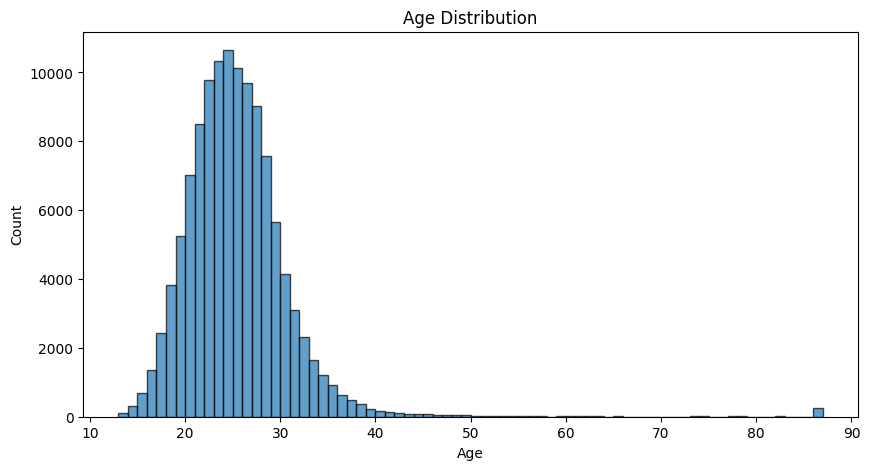

In [248]:
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.hist(ages_expanded, bins=range(min(ages['age']), max(ages['age'])), edgecolor='black', alpha=0.7)
ax.set_title('Age Distribution')
ax.set_xlabel('Age')
ax.set_ylabel('Count')
plt.show()

The results above allow us to see that the reported ages of people in the anime community seem to be normally distributed with a mean around 25 years.

### Country mapping and extraction

In [249]:
cities = pd.read_csv('Data/tableCities.csv', usecols=[1,5,6,10],header=None,names=['City','Country','Country_iso','Population'])
# In cases when multiple cities share the same name, we keep the ones with higher population
# Since the probability of being in Paris, France is more than 100 times higher than in Paris, Texas
cities.dropna()
cities = cities.sort_values(by='Population', ascending=False)
cities = cities.drop_duplicates(subset=['City'], keep='first')

In [250]:
city_to_country = dict(zip(cities['City'].str.lower(), cities['Country'].values.tolist()))
country_abbr_to_country = dict(zip(cities['Country_iso'].str.upper(), cities['Country']))
def infer_country(location, city_to_country, country_abbr_to_country):
    location = location.lower().strip()
    
    # Check for country name in the location string
    for country in country_abbr_to_country.values():
        if country.lower() in location:
            return country
    
    # Check for country in iso format
    if location.upper() in country_abbr_to_country:
        return country_abbr_to_country[location.upper()]
    
     # Check for exact city match
    if location in city_to_country:
        return city_to_country[location]
    
    # If no match found
    return 'Unknown'

In [251]:
users['country'] = users['location'].apply(lambda loc: infer_country(loc, city_to_country, country_abbr_to_country))
users = users[users['country'] != 'Unknown']

In [252]:
countries = users.groupby('country').size().reset_index(name='count')
countries.rename(columns={'country': 'SOVEREIGNT', 'count': 'User_Count'}, inplace=True)

Plotting user counts by country
###### this code looks awful but that's normal when working with pyplot

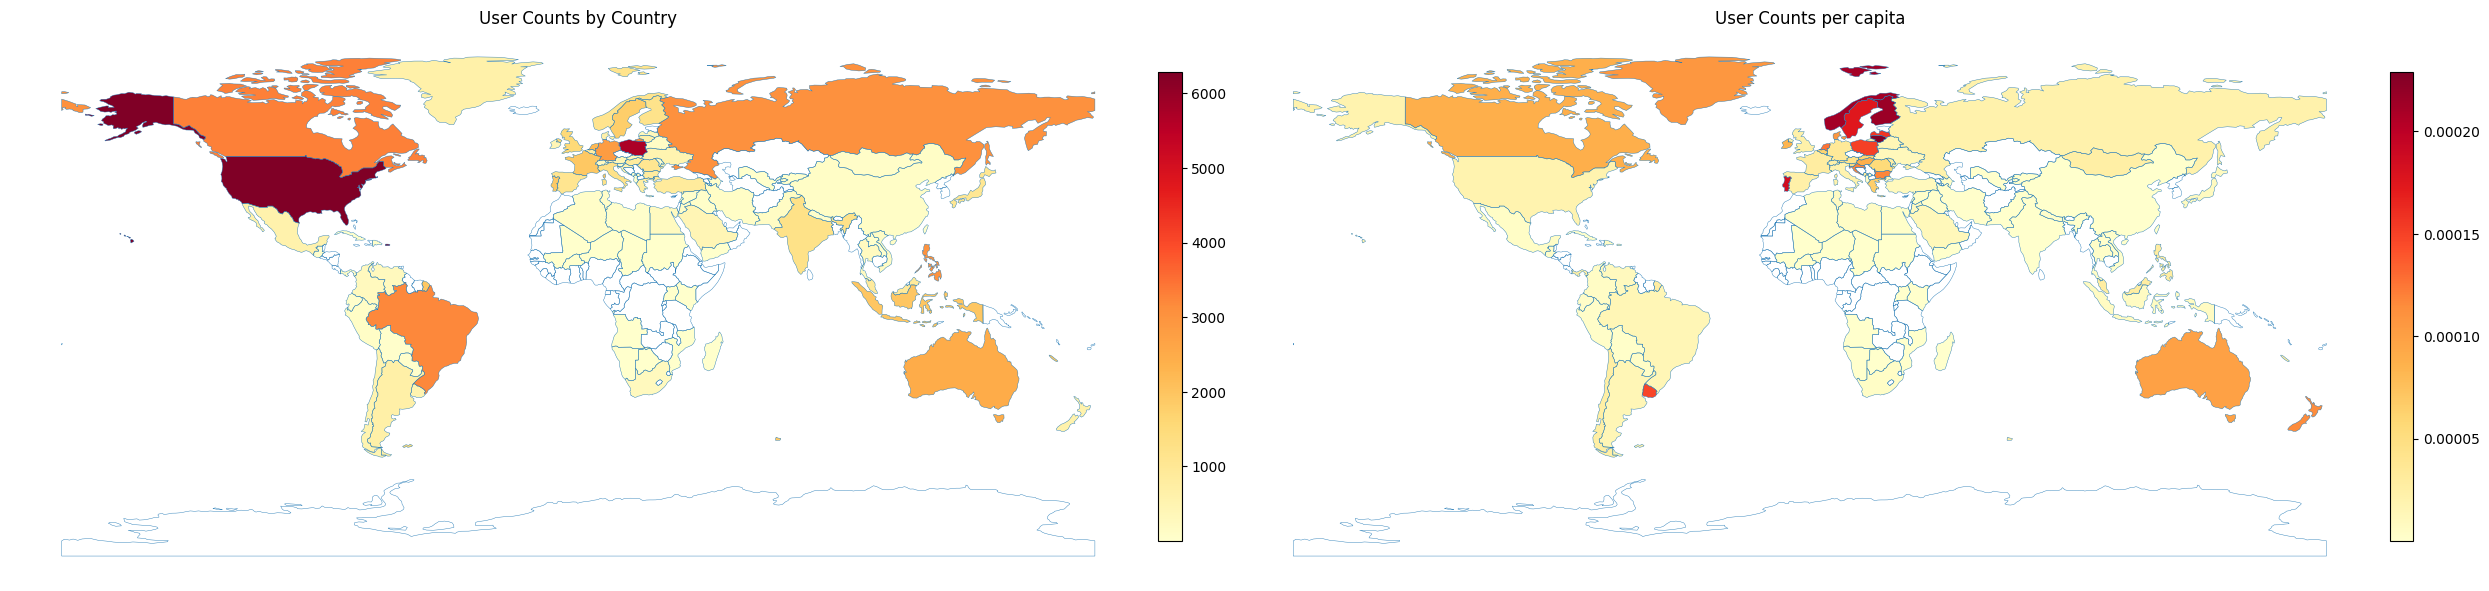

In [253]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(25, 10))


world = gpd.read_file('Data/ne_110m_admin_0_sovereignty/ne_110m_admin_0_sovereignty.shp')
world = world.merge(countries, how='left', on='SOVEREIGNT')
world.boundary.plot(ax=ax1, linewidth=0.3)
choropleth = world.plot(column='User_Count', ax=ax1, legend=False, cmap='YlOrRd')


world_adjusted  = world.copy()
world_adjusted['User_Count'] = world_adjusted['User_Count'] / world_adjusted['POP_EST']
world_adjusted.boundary.plot(ax=ax2, linewidth=0.3)
choropleth_adjusted = world_adjusted.plot(column='User_Count', ax=ax2, legend=False, cmap='YlOrRd')
# Create colorbar
sm = plt.cm.ScalarMappable(cmap='YlOrRd',norm=mcolors.Normalize(vmin=world['User_Count'].min(), vmax=world['User_Count'].max()))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax1, orientation='vertical', fraction=0.02, pad=0.01)

sm2 = plt.cm.ScalarMappable(cmap='YlOrRd',norm=mcolors.Normalize(vmin=world_adjusted['User_Count'].min(), vmax=world_adjusted['User_Count'].max()))
sm2.set_array([])
cbar2 = fig.colorbar(sm2, ax=ax2, orientation='vertical', fraction=0.02, pad=0.01)
ax1.axis('off')
ax1.set_title('User Counts by Country')
ax2.axis('off')
ax2.set_title('User Counts per capita')
plt.tight_layout()
plt.show()

The choropleth graph shows an interesting picture. It appears that the largest demographic of this website is in the United States, but the second-largest is in Poland.

Even after adjusting for the population, Poland still appears to be among the highest.